In [1]:
import os

import torch
from torch.utils.data import SubsetRandomSampler

from src.dataset import ImageDataset
from src.utils import get_indices

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Dataset part used for testing
TEST_SPLIT = 0.2
# Batch size for training. Limited by GPU memory
BATCH_SIZE = 6
# Dataset folder used
DATASET_USED = 'e9_5_GLM87a_cycle1_8_8'
# Full Dataset path
DATASET_PATH = os.path.join('data\mip2edof_2samples', DATASET_USED)
# Training Epochs
EPOCHS = 20

c:\Users\jurri\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\jurri\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

## 1 Initiate train and test loader

In [2]:
image_dataset = ImageDataset(DATASET_PATH, DATASET_USED)

train_indices, test_indices = get_indices(len(image_dataset), image_dataset.root_dir, TEST_SPLIT)
train_sampler, test_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(test_indices)

trainloader = torch.utils.data.DataLoader(image_dataset, BATCH_SIZE, sampler=train_sampler)
testloader = torch.utils.data.DataLoader(image_dataset, 1, sampler=test_sampler)

c:\Users\jurri\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


## 1.1 Show example of images

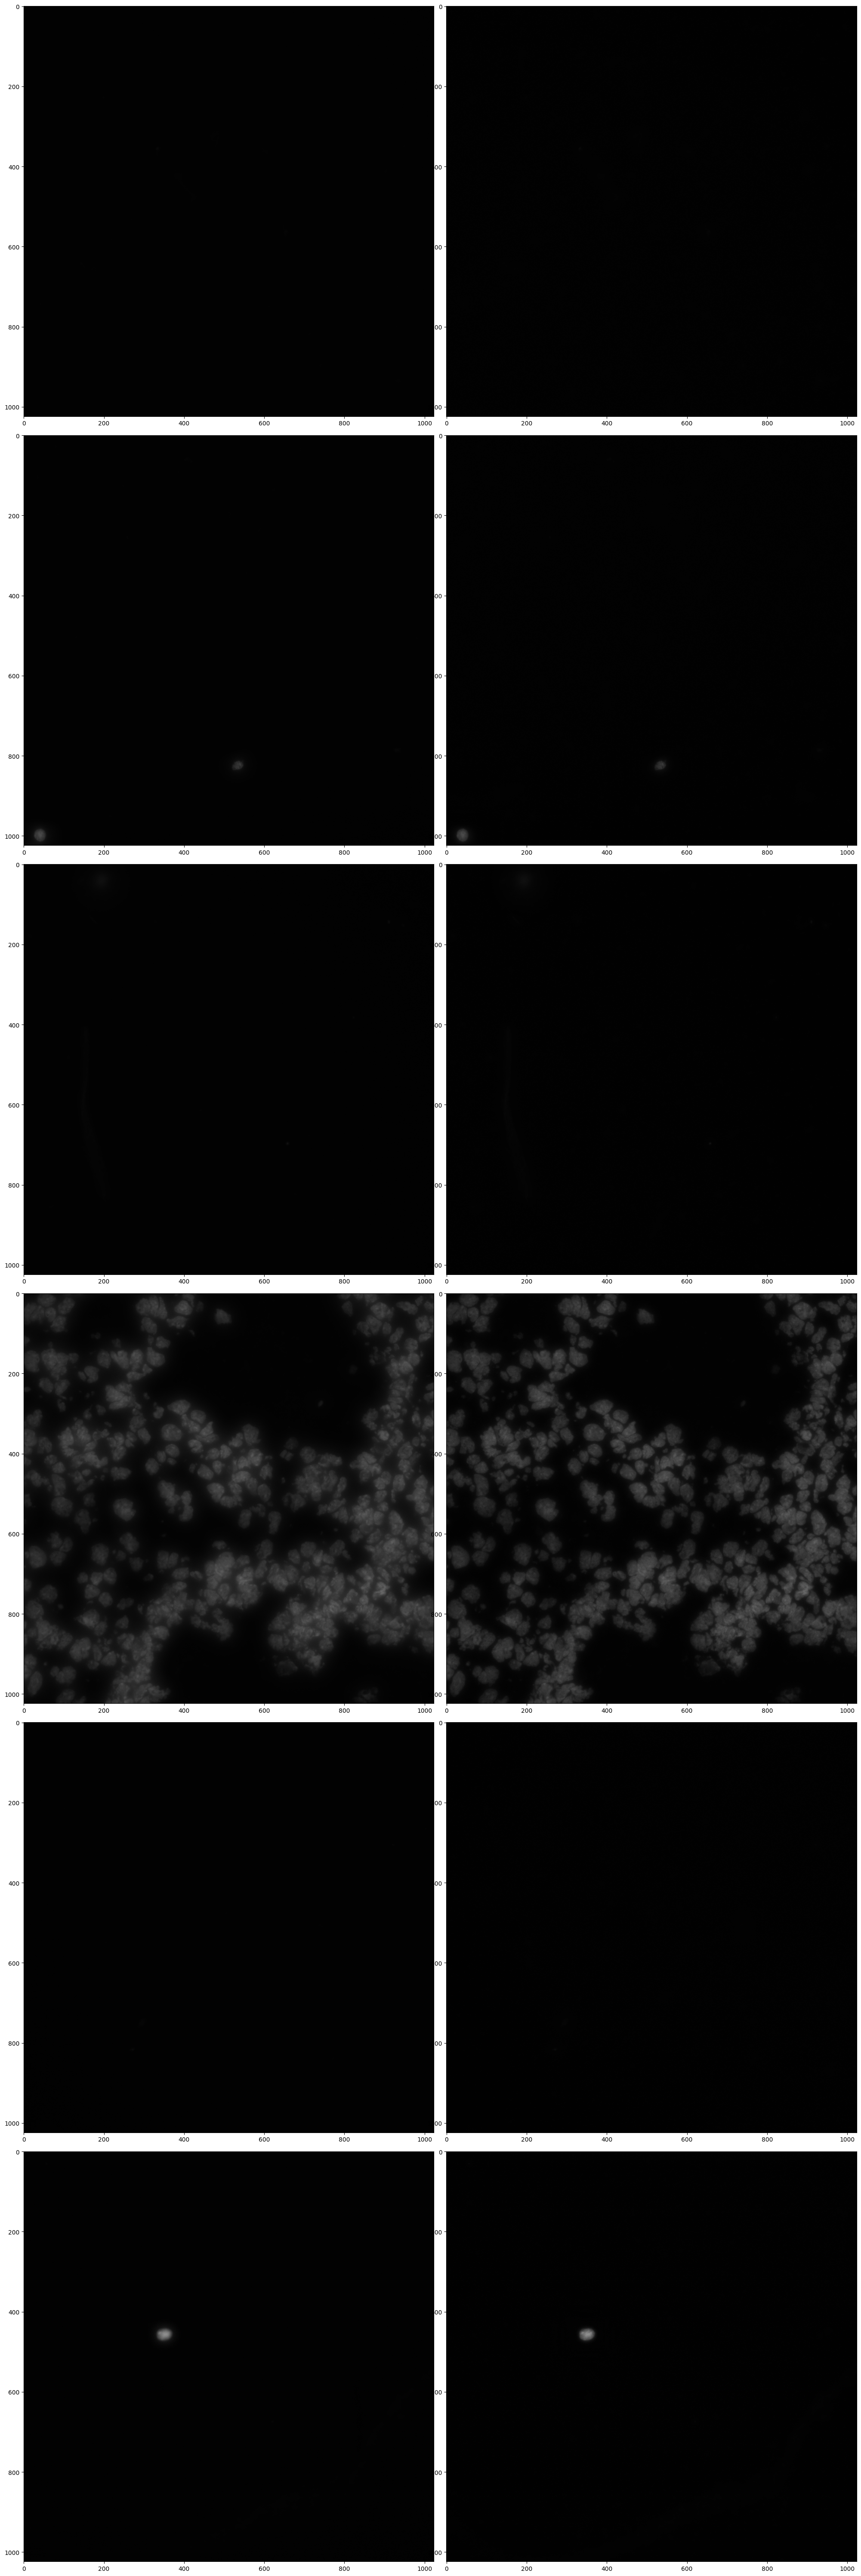

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(20, 60))
for data in trainloader:
    input_image = data['input_image'].squeeze().permute(1, 2, 0)
    output_image = data['output_image'].squeeze().permute(1, 2, 0)
    for i in range(input_image.shape[2]):
        ax[i,0].imshow(input_image[:,:,i], cmap='gray', vmin=0, vmax=16383, aspect='equal')
        ax[i,1].imshow(output_image[:,:,i], cmap='gray', vmin=0, vmax=16383, aspect='equal')
    break

plt.tight_layout()